In [1]:
import CASBI.utils as utils
from CASBI.generator import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [3]:
training_set = pd.read_parquet('../../data/dataframe/dataframe.parquet')

conditions = training_set.columns.difference(['feh', 'ofe', 'Galaxy_name'], sort=False)
conditions_set = training_set[conditions]

In [4]:
len(training_set['Galaxy_name'].unique())

4401

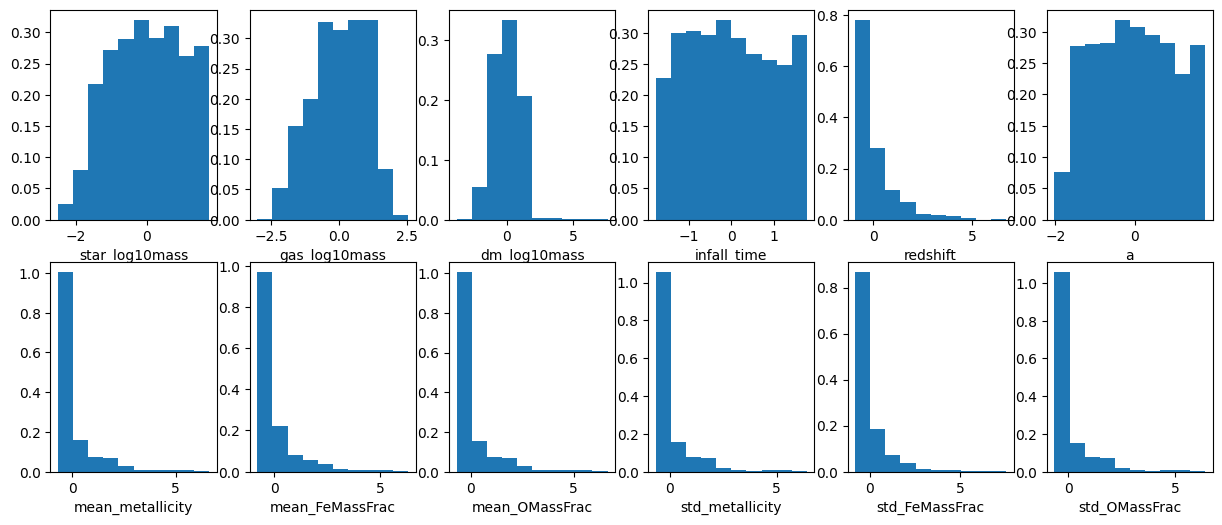

In [5]:
fig = plt.figure(figsize=(15, 6))
for i, con in enumerate(conditions_set.columns):
    ax = fig.add_subplot(2, int(len(conditions_set.columns)/2), i+1)
    ax.hist(conditions_set[con], density=True)
    ax.set_xlabel(con)
    

In [6]:
def get_even_space_sample(df_mass_masked):
    '''
    Given a dataframe of galaxy in a range of mass, it returns 20 equally infall time spaced samples  
    '''
    len_infall_time = len(df_mass_masked['infall_time'].unique())
    index_val_time = np.linspace(0, len_infall_time-1, 20)
    time = np.sort(df_mass_masked['infall_time'].unique())[index_val_time.astype(int)]
    df_time = pd.DataFrame(columns=df_mass_masked.columns)
    for t in time:
        temp = df_mass_masked[df_mass_masked['infall_time']==t]
        galaxy_temp = temp.sample(1)['Galaxy_name'].values[0]
        df_galaxy = df_mass_masked[df_mass_masked['Galaxy_name']==galaxy_temp]
        df_time = pd.concat([df_time, df_galaxy])
    return df_time
    
    
def load_train_objs(train_set):
    
    low_percentile_mass, high_percentile_mass = np.percentile(train_set['star_log10mass'], 25), np.percentile(train_set['star_log10mass'], 75)
    low_mass = get_even_space_sample(train_set[train_set['star_log10mass']<=low_percentile_mass])
    intermediate_mass = get_even_space_sample(train_set[(train_set['star_log10mass']>low_percentile_mass) & (train_set['star_log10mass']<high_percentile_mass)])
    high_mass = get_even_space_sample(train_set[train_set['star_log10mass']>=high_percentile_mass])
    val_set = pd.concat([low_mass, intermediate_mass, high_mass])
    
    train_set = train_set[~train_set['Galaxy_name'].isin(val_set['Galaxy_name'])]
    
    low_percentile_mass, high_percentile_mass = np.percentile(train_set['star_log10mass'], 25), np.percentile(train_set['star_log10mass'], 75)
    low_mass = get_even_space_sample(train_set[train_set['star_log10mass']<=low_percentile_mass])
    intermediate_mass = get_even_space_sample(train_set[(train_set['star_log10mass']>low_percentile_mass) & (train_set['star_log10mass']<high_percentile_mass)])
    high_mass = get_even_space_sample(train_set[train_set['star_log10mass']>=high_percentile_mass])
    test_set = pd.concat([low_mass, intermediate_mass, high_mass])
    
    train_set = train_set[~train_set['Galaxy_name'].isin(test_set['Galaxy_name'])]
    
    return train_set, val_set, test_set

In [7]:
train_set, val_set, test_set = load_train_objs(training_set)

/tmp/ipykernel_741729/4132125250.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_time = pd.concat([df_time, df_galaxy])
/tmp/ipykernel_741729/4132125250.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_time = pd.concat([df_time, df_galaxy])
/tmp/ipykernel_741729/4132125250.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtyp

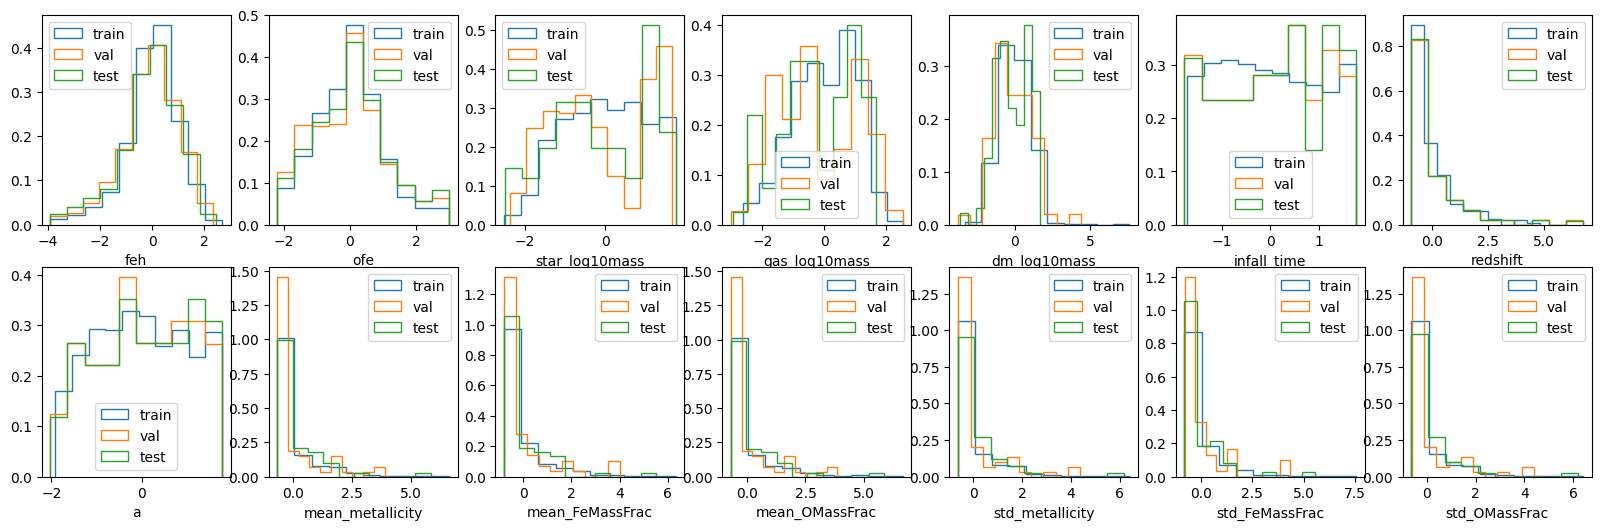

In [8]:
fig = plt.figure(figsize=(20, 6))
for i, con in enumerate(train_set.columns[:-1]):
    ax = fig.add_subplot(2, int(len(train_set.columns)/2), i+1)
    ax.hist(train_set[con], density=True, label='train', histtype='step')
    ax.hist(val_set[con], density=True, label='val', histtype='step')
    ax.hist(test_set[con], density=True, label='test', histtype='step')
    ax.legend()
    ax.set_xlabel(con)
